# Q-Learning Algorithms and their Application to Optimal Trading Problems:
## The Q-learning implementation

The goal of the algorithm: take a mean reverting strategy once you are at the bounds

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn, rand, seed
from tqdm.notebook import tqdm
import xarray as xr
import seaborn as sns 

In [3]:
%precision 4
%config InlineBackend.figure_format = "retina"

## The Ornstein-Uhlenbeck process

$$
    dS_{t+1} = \kappa(\bar S - S_t) + \sigma dW_t
$$

Where
* $\kappa$ is the force of the mean-reverting effect
* $\bar S$ is the mean-reverting value
* $\sigma$ is the *stardard* deviation of the process

In [4]:
# Going from (kappa, theta, sigma) -> (alpha, beta, gamma)
# does not seem to work properly (variance is way too low)
dt = 1 / 60
kappa, theta, sigma = 1e-5, 1, 2

alpha = theta * (1 - np.exp(-kappa * dt))
beta = np.exp(-kappa * dt)
gamma = np.sqrt(sigma ** 2 * (1 - np.exp(-2 * kappa * dt)) / (2 * kappa))

$$
    X_{t_i + 1} = \alpha + \beta X_{t_i}
$$

In [5]:
alpha, beta, gamma

(1.6666665281217519e-07, 0.9999998333333472, 0.25819886822283034)

In [6]:
timesteps = 500
t = np.linspace(0, 2, timesteps)

alpha, beta = .08, 0.98
gamma = .2
e_t = randn(timesteps) * gamma

In [7]:
seed(314)
x0 = 1.5
X = np.zeros(timesteps)
for t in range(timesteps):
    if t == 0:
        X[t] = x0
    else:
        X[t] = alpha + beta * X[t-1] + e_t[t-1]
X = X

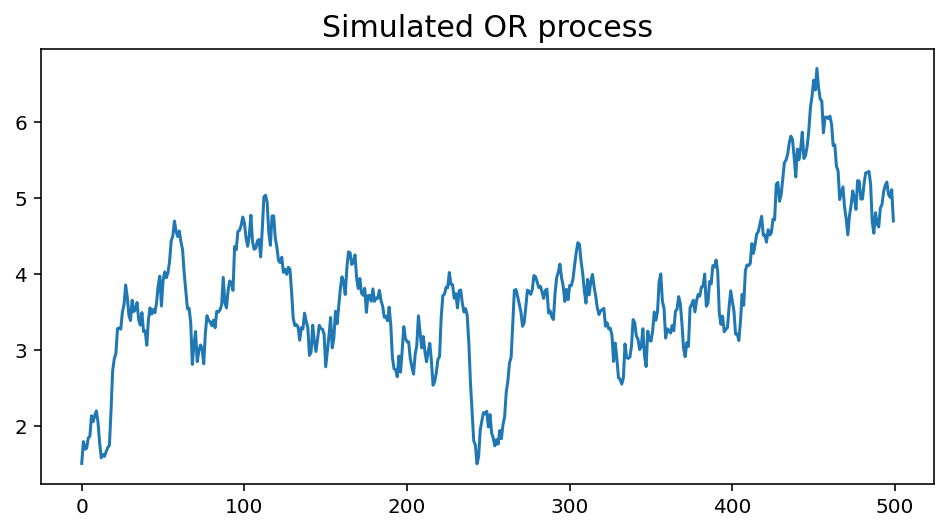

In [8]:
plt.figure(figsize=(8, 4))
plt.title("Simulated OR process", fontsize=15)
plt.plot(X);

We consider a three-tuple state that takes us to a single action

```
* T: terminal time (0, T)
* N: intermediate trading periods
* A: Number of shares traded at a single period
* Q: Current inventory
```

In [9]:
T, N, A, Q = 1, 1, 1, 1
Q = np.zeros((T, N, A, Q))

In [10]:
sigma = np.sqrt(2 * gamma ** 2 * np.log(beta) / (beta ** 2 - 1))
sigma

0.20202363756848574

In [11]:
n = 3.5
xmin, xmax = theta + np.array([-1, 1]) *  n * sigma / np.sqrt(2 * kappa)
xmin, xmax

(-157.10850533272006, 159.10850533272006)

In [12]:
# When we simulate our price path, we bin our observations
# into into intervals degined by the grid-points
M = 100
delta_x = (xmax - xmin) / M
bins = np.arange(M) * delta_x + xmin

## Implementation

In [13]:
def simulate_ou_process(x0, xbar, kappa, sigma, T, dt):
    time = np.arange(0, T, dt)
    nsteps = len(time)
    x = np.zeros(nsteps)
    x[0] = x0
    errs = np.random.randn(nsteps - 1)
    
    cnst0 =  (1 - kappa * dt)
    cnst1 = dt * kappa * xbar
    cnst2 = np.sqrt(dt) * sigma
    for t in range(nsteps - 1):
        x[t + 1] = x[t] + dt * (kappa * (xbar - x[t])) + np.sqrt(dt) * sigma * errs[t]
        x[t + 1] = x[t] * cnst0 + cnst1 + cnst2 * errs[t]
        

    return time, x

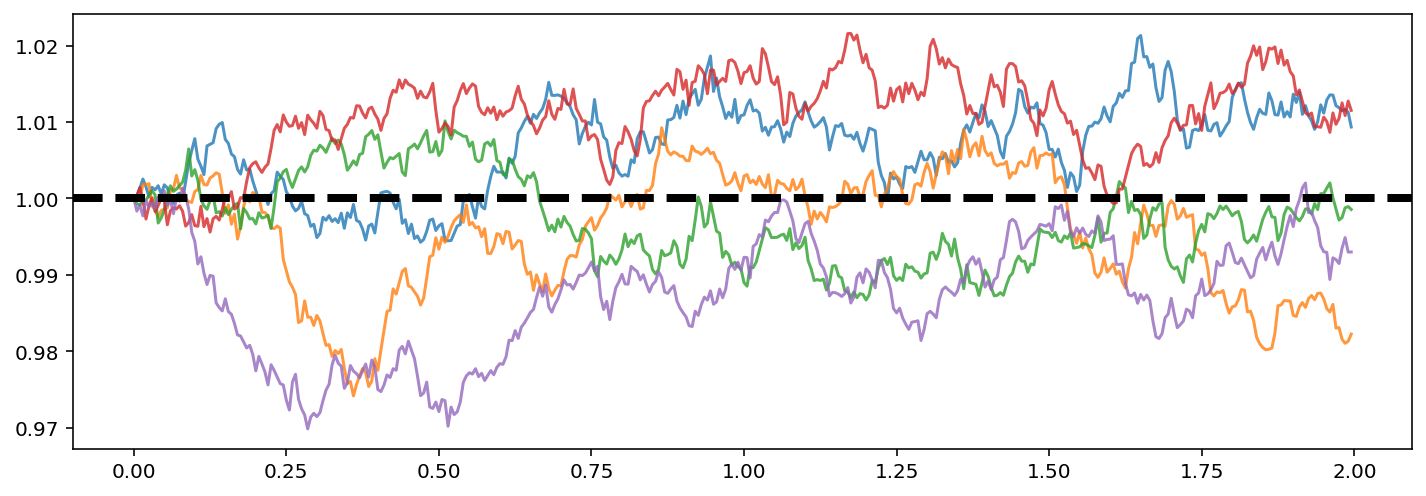

In [14]:
seed(314)
xbar = 1
plt.figure(figsize=(12, 4))
for _ in range(5):
    plt.plot(*simulate_ou_process(1, xbar, 1, 0.02, T=2, dt=0.005),
             alpha=0.8)
plt.axhline(y=xbar, linewidth=4, c="black", linestyle="--");

Reward at time $t_i$


$$
    R_i = q_{t_i} (X_{t_{i+1}} - X_{t_{i}}) - \phi a_{t_i}^2
$$

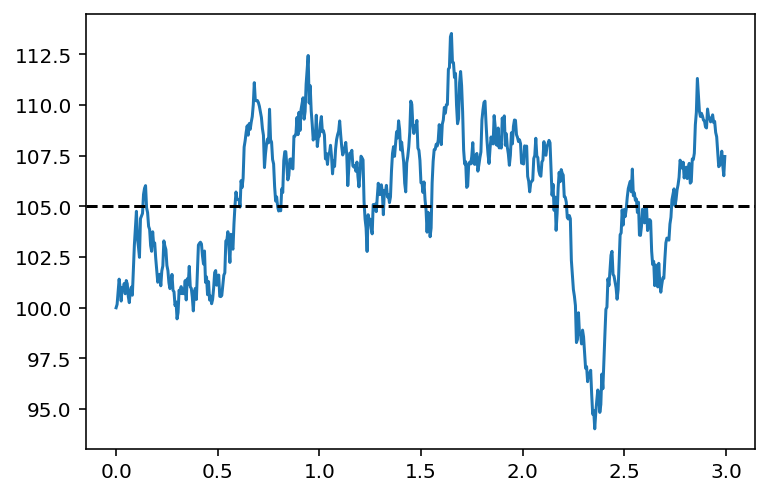

In [15]:
seed(314)
T, dt = 3, 0.005
x0, kappa, xbar, sigma = 100, 2, 105, 10
t, Xt = simulate_ou_process(x0, xbar, kappa, sigma, T, dt)
plt.plot(t, Xt)
plt.axhline(y=xbar, c="black", linestyle="--")

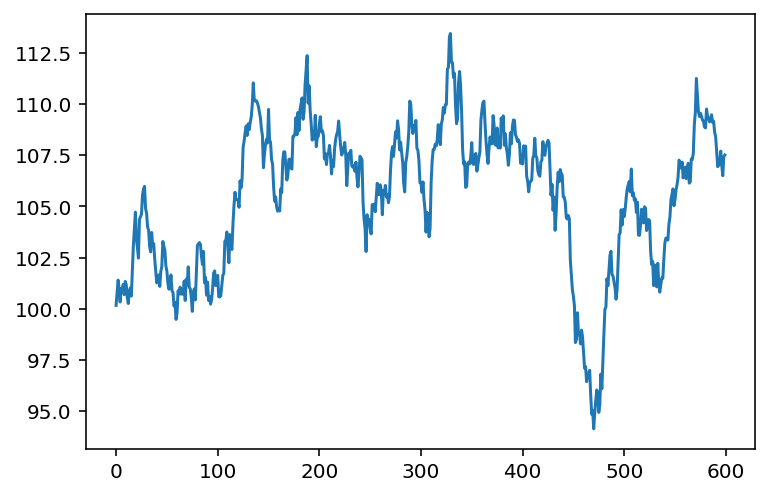

In [16]:
seed(314)
nv = 600
errs = randn(nv)
cnst0 =  (1 - kappa * dt)
cnst1 = dt * kappa * xbar
cnst2 = np.sqrt(dt) * sigma

xnum = (cnst1 * np.cumsum(cnst0 ** np.arange(0., nv))
      + cnst2 * ((cnst0 ** np.tril(np.ones((nv, nv))).cumsum(axis=0) -
                  np.triu(np.ones((nv, nv)), k=1)) * errs[None, :]).sum(axis=1)
      + cnst0 ** np.arange(1., nv + 1.) * x0)

plt.plot(xnum)

In [17]:
def simulate_ou_process_v2(x0, xbar, kappa, sigma, T, dt):
    time = np.arange(0, T, dt)
    nsteps = len(time)
    errs = np.random.randn(nsteps - 1)
    
    cnst0 =  (1 - kappa * dt)
    cnst1 = dt * kappa * xbar
    cnst2 = np.sqrt(dt) * sigma
    
    nsteps -= 1
    ones_matrix = np.ones((nsteps, nsteps))
    power_terms = cnst0 ** np.tril(ones_matrix).cumsum(axis=0) - np.triu(ones_matrix, k=1)
    
    first_term = cnst1 * np.cumsum(cnst0 ** np.arange(nsteps))
    second_term = (cnst2 * power_terms * errs[None, :]).sum(axis=1)
    third_term = cnst0 ** np.arange(1, nsteps + 1) * x0
    
    x = first_term + second_term + third_term
    x = np.insert(x, 0, x0)
    
    return time, x

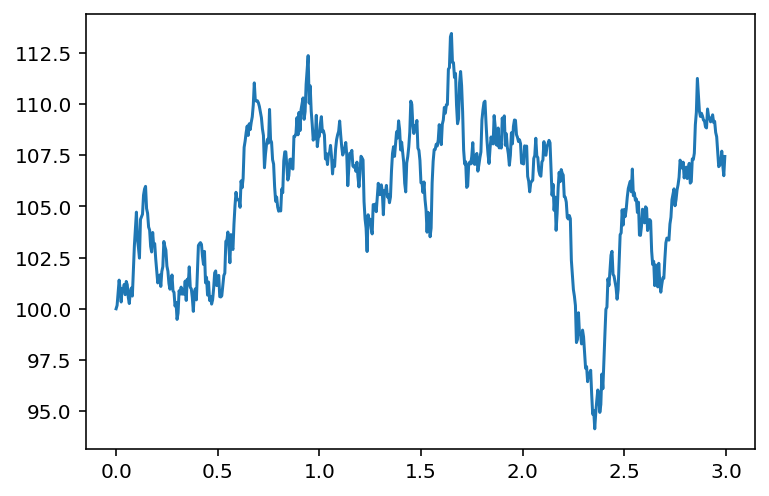

In [18]:
seed(314)
T = 3
t, Xt = simulate_ou_process_v2(x0, xbar, kappa, sigma, T, dt)
plt.plot(t, Xt)

In [19]:
seed(314)

def simulate_ou_process_v2(x0, xbar, kappa, sigma, T, dt):
    time = np.arange(0, T, dt)
    nsteps = len(time)
    x[0] = x0
    errs = randn(nsteps - 1)
    nsteps = 600
    errs = randn(nsteps - 1)

    cnst0 =  (1 - kappa * dt)
    cnst1 = dt * kappa * xbar
    cnst2 = np.sqrt(dt) * sigma

    nsteps -= 1
    ones_matrix = np.ones((nsteps, nsteps))
    power_terms = cnst0 ** np.tril(ones_matrix).cumsum(axis=0) - np.triu(ones_matrix, k=1)

    first_term = cnst1 * np.cumsum(cnst0 ** np.arange(nsteps))
    second_term = (cnst2 * power_terms * errs[None, :]).sum(axis=1)
    third_term = cnst0 ** np.arange(1, nsteps + 1) * x0

    x = first_term + second_term + third_term

In [61]:
%%time
T = 100
t, Xt = simulate_ou_process(x0, xbar, kappa, sigma, T, dt)

CPU times: user 96.1 ms, sys: 3.2 ms, total: 99.3 ms
Wall time: 101 ms


In [21]:
import dask
import numpy as np
import dask.array as da

In [22]:
def simulate_ou_process_v3(x0, xbar, kappa, sigma, T, dt):
    time = np.arange(0, T, dt)
    nsteps = len(time)
    chunk = 500_000

    cnst0 =  (1 - kappa * dt)
    cnst1 = dt * kappa * xbar
    cnst2 = da.sqrt(dt) * sigma
    
    errs = da.random.normal(1, nsteps - 1, chunks=(chunk))
    ones_matrix = da.ones((nsteps, nsteps), chunks=(chunk, chunk))
    steps_elements = da.arange(nsteps + 1, chunks=(chunk))
    
    tril_array = da.tril(ones_matrix)
    triu_array = tril_array.T - da.eye(nsteps)
    
    power_terms = cnst0 ** tril_array.cumsum(axis=0) - triu_array
    first_term = cnst1 * da.cumsum(cnst0 ** steps_elements[:-1])
    second_term = (cnst2 * power_terms * errs).sum(axis=1)
    third_term = cnst0 ** steps_elements[1:] * x0

    x = first_term + second_term + third_term
    
    return x

In [23]:
T, dt = 3, 0.005
x0, kappa, xbar, sigma = 100, 2, 105, 10

In [114]:
T = 50
Xt = simulate_ou_process_v3(x0, xbar, kappa, sigma, T, dt)

/Users/gerardoduran/miniconda3/lib/python3.7/multiprocessing/semaphore_tracker.py:55: UserWarning: semaphore_tracker: process died unexpectedly, relaunching.  Some semaphores might leak.
  warnings.warn('semaphore_tracker: process died unexpectedly, '


%%time
ans = Xt.compute(scheduler="processes")

In [88]:
%%time
ans = Xt.rechunk(chunks=50_000)
ans = ans.compute()

CPU times: user 52.6 s, sys: 9.87 s, total: 1min 2s
Wall time: 40.9 s


In [24]:
%%time
T = 100
t, Xt = simulate_ou_process(x0, xbar, kappa, sigma, T, dt)
print(Xt.shape)

(20000,)
CPU times: user 95.6 ms, sys: 3.75 ms, total: 99.3 ms
Wall time: 101 ms


In [25]:
Qm = xr.load_dataarray("./Q-trading.nc")

In [26]:
sell_min, buy_max = 5, 5
phi = 0.01
Qmin, Qmax = -10, 10
bucket_size = 0.5
xmin, xmax = 90, 115
prices = np.arange(xmin, xmax, 1)
inventory = np.arange(-50, 50)
actions = np.arange(-sell_min, buy_max)

In [27]:
prices = np.round(prices, 1)

Reward at time $t_i$


$$
    R_i = \mathbb{E}\left[(q_{t_i} + a_{t_i})  (X_{t_{i+1}} - X_{t_{i}}) - \phi a_{t_i}^2\right]
$$

In [28]:
Xt[1] - Xt[0]

-0.2032181818216685

In [29]:
def exploration_rate(C, D, k):
    return C / (D + k)

def learning_rate(A, B, k):
    return A / (B + k)

exploration_rate(50, 50, 0)

1.0000

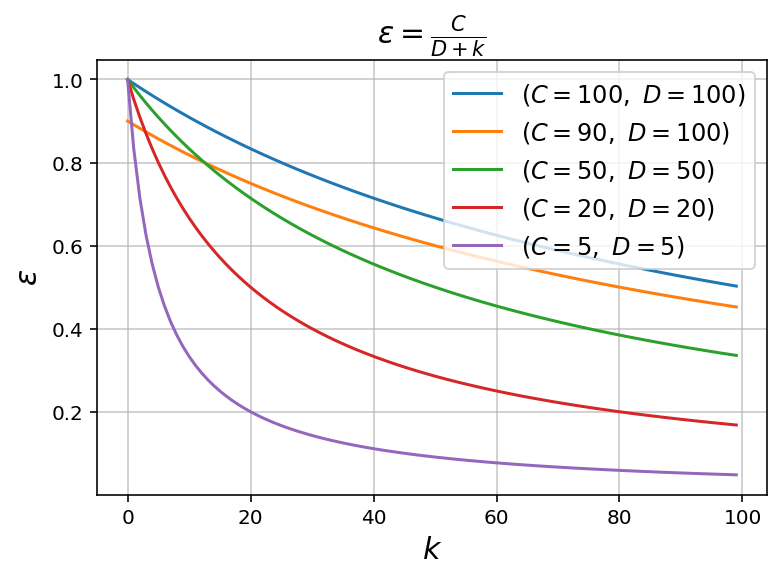

In [30]:
K = np.arange(100)
configurations = [(100, 100), (90, 100), (50, 50), (20, 20), (5, 5)]
for C, D in configurations:
    plt.plot(K, exploration_rate(C, D, K), label=rf"$(C={C}, \ D={D})$")
    plt.ylabel(r"$\epsilon$", fontsize=15)
    plt.xlabel(r"$k$", fontsize=15)
    plt.grid(alpha=0.7)
plt.title(r"$\epsilon = \frac{C}{D + k}$", fontsize=15)
plt.legend(fontsize=12);

Evidently $C \leq D$ for $\epsilon$ to be a valid probability.

In [31]:
np.set_printoptions(linewidth=110)

actions = np.arange(-sell_min, buy_max + 1, dtype=np.float32)
inventory = np.arange(Qmin, Qmax + 1, dtype=np.float32)
# Inventory X Purchase
action_space = actions[None, :] + inventory[:, None]
df_action = pd.DataFrame(action_space.copy(), columns=actions, index=inventory)

In [ ]:
possible_actions = df_action.loc[q]
possible_actions = possible_actions[(Qmin <=  possible_actions) & (possible_actions <= Qmax)]

In [21]:
action_map = (Qmin <= action_space) & (action_space <= Qmax)
action_space[~action_map] = np.nan
action_space[action_map] = 1.

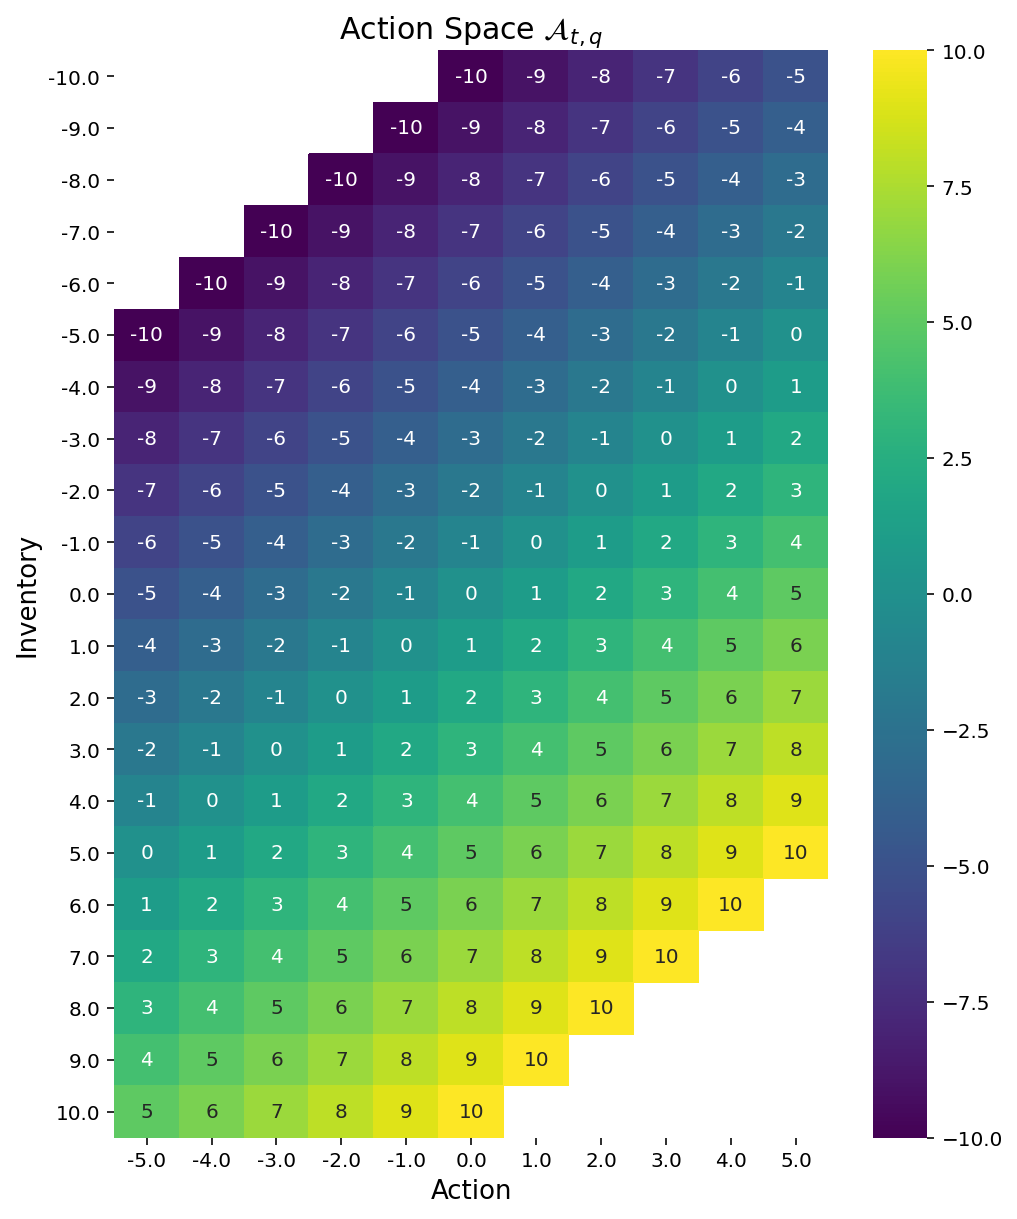

In [22]:
plt.figure(figsize=(8, 10))
plt.title(r"Action Space $\mathcal{A}_{t, q}$", fontsize=15)
sns.heatmap(df_action, annot=True, cmap="viridis", mask=~action_map)
plt.xlabel("Action", fontsize=13)
plt.ylabel("Inventory", fontsize=13);

In [23]:
phi, c = 0.01, 0.5

In [73]:
# ["time", "price", "inventory", "action"]
# Step 1: simulate the process
timesteps, Xt = simulate_ou_process(x0, xbar, kappa, sigma, T, dt)

In [24]:
timesteps = np.round(timesteps, 4)
Xt = Xt.round(0)
Xt = np.clip(Xt, xmin, prices.max())

R = np.diff(Xt)[:, None, None] * inventory[None, :, None] - phi * actions[None, None, :]
R[-1, :, :] = R[-1, :, :] - c * inventory[:, None]
R = R * action_space[None, :]

In [71]:
buckets = np.round(sigma * np.sqrt(dt) / 4, 4)
buckets

0.1768

In [78]:
Xt.min(), Xt.max()

(85.25381333402578, 122.75635093453992)

In [25]:
reward_dimensions = ["timestep", "inventory", "action"]
Rm = xr.DataArray(R, coords=[timesteps[1:], inventory, actions], dims=reward_dimensions)

In [26]:
n_actions = len(actions)
n_inventory = len(inventory)

In [27]:
# Initialize Q-matrix
Q = np.zeros((len(timesteps), len(prices), n_inventory, n_actions))
Q = action_space[None, None, :, :] * Q

In [28]:
dimensions = ["time", "price", "inventory", "action"]
Qm = xr.DataArray(Q, coords=[timesteps, prices, inventory, actions], dims=dimensions)

In [32]:
k = 0
t, q = 0, 0
A, B, C, D = 50, 50, 100, 100
for ix, t in enumerate(timesteps[:-1]):
    # With probability epsilon select an action a
    # uniformly at random from Atq
    if rand() < exploration_rate(50, 50, k):
        possible_actions = df_action.loc[q]
        possible_actions = possible_actions[(Qmin <=  possible_actions) & (possible_actions <= Qmax)]
        new_action = possible_actions.sample().index[0]
    else:
        new_action = Qm.sel(time=t, inventory=q, price=Xt[ix])["action"].idxmax()

    q_prime  = q + new_action
    t_prime = (t + dt).round(3)

    reward = Rm.sel(timestep=t_prime, inventory=q_prime, action=new_action).values.max()
    alpha_k = learning_rate(A, B, k)

    selection_current = dict(time=t, inventory=q, price=Xt[0], action=new_action)
    selection_next = dict(time=t_prime, inventory=q_prime, price=Xt[ix + 1])
    Q_next = Qm.loc[selection_next].values.max()

    Q_update_value = (1 - alpha_k) * Qm.loc[selection_current] + alpha_k * (reward + gamma * Q_next)
    Qm.loc[selection_current] = Q_update_value

In [113]:
dict(time=0)

{'time': 0}

In [112]:
Qm.loc[{"time": 0}]

<xarray.DataArray (price: 25, inventory: 21, action: 11)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
    time       float64 0.0
  * price      (price) int32 90 91 92 93 94 95 96 ... 109 110 111 112 113 114
  * inventory  (inventory) float32 -10.0 -9.0 -8.0 -7.0 ... 7.0 8.0 9.0 10.0
  * action     (action) float32 -5.0 -4.0 -3.0 -2.0 -1.0 0.0 1.0 2.0 3.0 4.0 5.0

In [38]:
possible_actions = df_action.loc[q]
possible_actions = possible_actions[(Qmin <=  possible_actions) & (possible_actions <= Qmax)]

In [81]:
if np.all(possible_actions == possible_actions.max()):
    print("yes")

yes


## Dirty Work

In [154]:
T = 10
dt = 0.05
timesteps, Xt = simulate_ou_process(x0, xbar, kappa, sigma, T, dt)
timesteps = np.round(timesteps, 4)

In [82]:
# Initialize Q-matrix
state_space = len(timesteps), len(prices), 10, 10
Q = np.random.randn(*state_space)
#Q = action_space[None, None, :, :] * Q

In [156]:
nits = 50_000
nits * len(timesteps) / np.prod(Q.shape)

8.658008658008658

In [124]:
sell_min, buy_max = 5, 5
phi = 0.01
Qmin, Qmax = -10, 10
bucket_size = 0.5
xmin, xmax = 90, 115
prices = np.arange(xmin, xmax, 1)
inventory = np.arange(-50, 50)
actions = np.arange(-sell_min, buy_max)

In [ ]:
import numpy as np

In [165]:
class QTrading:
    def __init__(self, kappa, sigma, xbar, phi, gamma, c,
                 T, dt, A, B, C, D, xmin=90, xmax=110, buy_min=-5,
                 buy_max=5, inventory_min=-20, inventory_max=20):
        """
        Constructor for the Q-learning program
        
        Parameters
        ----------
        kappa: float
            mean-reverting force
        sigma: float
            noise parameter
        xbar: float
            mean-reverting value
        phi: float
            penalty parameter for the action
        gamma: float
            discount factor of the reinforcement learner
        c: foat
            penalty for inventory
        T: float
            Time duration
        dt: float
            timestep change
        A: int
            
        B: int
        
        C: int
        
        D: int
        
        """
        self.kappa = kappa
        self.sigma = sigma
        self.xbar = xbar
        self.phi = phi
        self.gamma = gamma
        self.T = T
        self.dt = dt
        self.A = A
        self.B = B
        self.C = C
        self.D = D
        self.inventory = np.arange(inventory_min, inventory_max)
        self.actions = np.arange(buy_min, buy_max)
        
    def simulate_ou_process(self):
        """
        Todo (Leo): generalizar a N simulaciones
        Puntos extra por quitar todos los for loops
        """
        time = np.arange(0, self.T, self.dt)
        nsteps = len(time)
        x = np.zeros(nsteps)
        x[0] = x0
        errs = randn(nsteps - 1)
        for t in range(nsteps - 1):
            x[t + 1] = x[t] + self.dt * (self.kappa * (self.xbar - x[t])) + np.sqrt(dt) * self.sigma * errs[t]
        
        return x
    
    def simulate_reward_matrix(self):
        Xt = self.simulate_ou_process()
        R = np.diff(Xt)[:, None, None] * self.inventory[None, :, None] - self.phi * self.actions[None, None, :]
        
        return R
    
    def q_learn(self):
        """
        to-do: implement
        """
        pass

In [178]:
kappa, sigma, xbar, phi, gamma, c, T, A, B, C, D

(1, 0.2000, 100, 0.0100, 0.2000, 0.3000, 2, 20, 20, 20, 20)

In [167]:
A, B, C, D = 20, 20, 20, 20
qtr = QTrading(kappa, sigma, xbar, phi, gamma, c, T, dt, A, B, C, D)

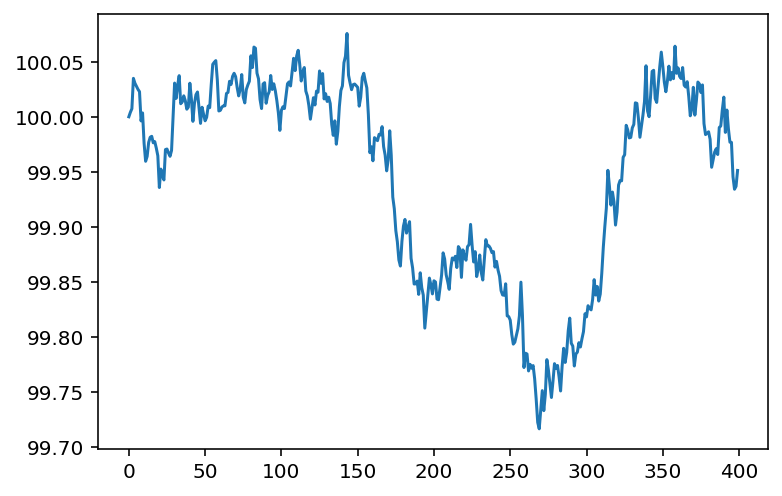

In [173]:
plt.plot(qtr.simulate_ou_process())

In [73]:
def simulate_ou_process(x0, xbar, kappa, sigma, T, dt):
    time = np.arange(0, T, dt)
    nsteps = len(time)
    x = np.zeros(nsteps)
    x[0] = x0
    errs = randn(nsteps - 1)
    for t in range(nsteps - 1):
        x[t + 1] = x[t] + dt * (kappa * (xbar - x[t])) + np.sqrt(dt) * sigma * errs[t]
    
    return time, x

In [88]:
R = np.diff(Xt)[:, None, None] * inventory[None, :, None] - phi * actions[None, None, :]

100.0000

In [127]:
inventory.shape

(100,)

In [129]:
# (ΔSt, inventory, action)
timesteps, Xt = simulate_ou_process(x0, xbar, kappa, sigma, T, dt)
np.diff(Xt)[:, None] .shape

(399, 1)

In [133]:
actions.shape

(10,)

In [130]:
inventory[None, :].shape

(1, 100)

In [152]:
R = np.diff(Xt)[:, None, None] * inventory[None, :, None] - phi * actions[None, None, :]
R[-1, :, :] = R[-1, :, :] - c * inventory[:, None]

In [144]:
c = 0.3

In [149]:
inventory.shape

(100,)

In [150]:
R[-1, :, :].shape

(100, 10)

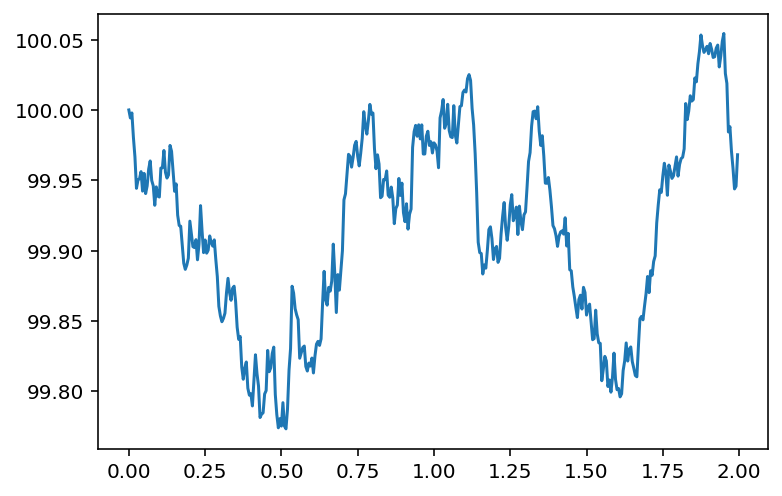

In [139]:
x0, xbar, kappa, sigma, T, dt = 100, 100, 1, 0.2, 2, 0.005
timesteps, Xt = simulate_ou_process(x0, xbar, kappa, sigma, T, dt)

plt.plot(timesteps, Xt)

In [103]:
possible_actions1 = df_action.loc[1]

In [106]:
possible_actions1

-5.0   -4.0
-4.0   -3.0
-3.0   -2.0
-2.0   -1.0
-1.0    0.0
 0.0    1.0
 1.0    2.0
 2.0    3.0
 3.0    4.0
 4.0    5.0
 5.0    6.0
Name: 1.0, dtype: float32

In [157]:
## Al together and dirty
A, B, C, D = 10, 10, 200, 200
dt = 0.1
dimensions = ["time", "price", "inventory", "action"]
Qm = xr.DataArray(Q.copy(), coords=[timesteps, prices, inventory, actions], dims=dimensions)

det, negatives, positives, nulls = 0, 0, 0, 0

eps_min = 0.4
for k in tqdm(range(nits)):
    timesteps, Xt = simulate_ou_process(x0, xbar, kappa, sigma, T, dt)
    timesteps = np.round(timesteps, 4)
    Xt = Xt.round(0)
    Xt = np.clip(Xt, xmin, prices.max())

    R = np.diff(Xt)[:, None, None] * inventory[None, :, None] - phi * actions[None, None, :]
    R[-1, :, :] = R[-1, :, :] - c * inventory[:, None]
    Rm = xr.DataArray(R, coords=[timesteps[1:], inventory, actions], dims=reward_dimensions)
    t, q = 0, 0
    for ix, t in enumerate(timesteps[:-1]):
        # With probability epsilon select an action a
        # uniformly at random from Atq
        possible_actions = df_action.loc[q]
        possible_actions = possible_actions[(Qmin <=  possible_actions) & (possible_actions <= Qmax)]
        
        eps_k = exploration_rate(C, D, k)
        eps_k = max(eps_k, eps_min)
        if rand() < eps_k:
            new_action = possible_actions.sample().index[0]
        else:
            list_actions = Qm.sel(time=t, inventory=q, price=Xt[ix], action=possible_actions.index)
            if np.all(list_actions == list_actions.max()):
                det += 1
                new_action = possible_actions.sample().index[0]
            else:
                new_action = list_actions.idxmax().values.max()

        q_prime  = q + new_action
        t_prime = (t + dt).round(3)
        
        if q_prime < 0:
            negatives += 1
        elif q_prime == 0:
            nulls += 1
        else:
            positives +=1
        print(f"{negatives:05}, {nulls:05}, {positives:05} : {det:05}", end="\r")

        reward = Rm.sel(timestep=t_prime, inventory=q_prime, action=new_action).values.max()
        alpha_k = learning_rate(A, B, k)

        selection_current = dict(time=t, inventory=q, price=Xt[ix], action=new_action)
        selection_next = dict(time=t_prime, inventory=q_prime, price=Xt[ix + 1])
        Q_next = Qm.loc[selection_next].values.max()

        Q_update_value = (1 - alpha_k) * Qm.loc[selection_current] + alpha_k * (reward + gamma * Q_next)
        Qm.loc[selection_current] = Q_update_value
        q = q_prime

2843754, 223238, 1883008 : 26209


In [164]:
# Qm.to_netcdf("Q-trading.nc")

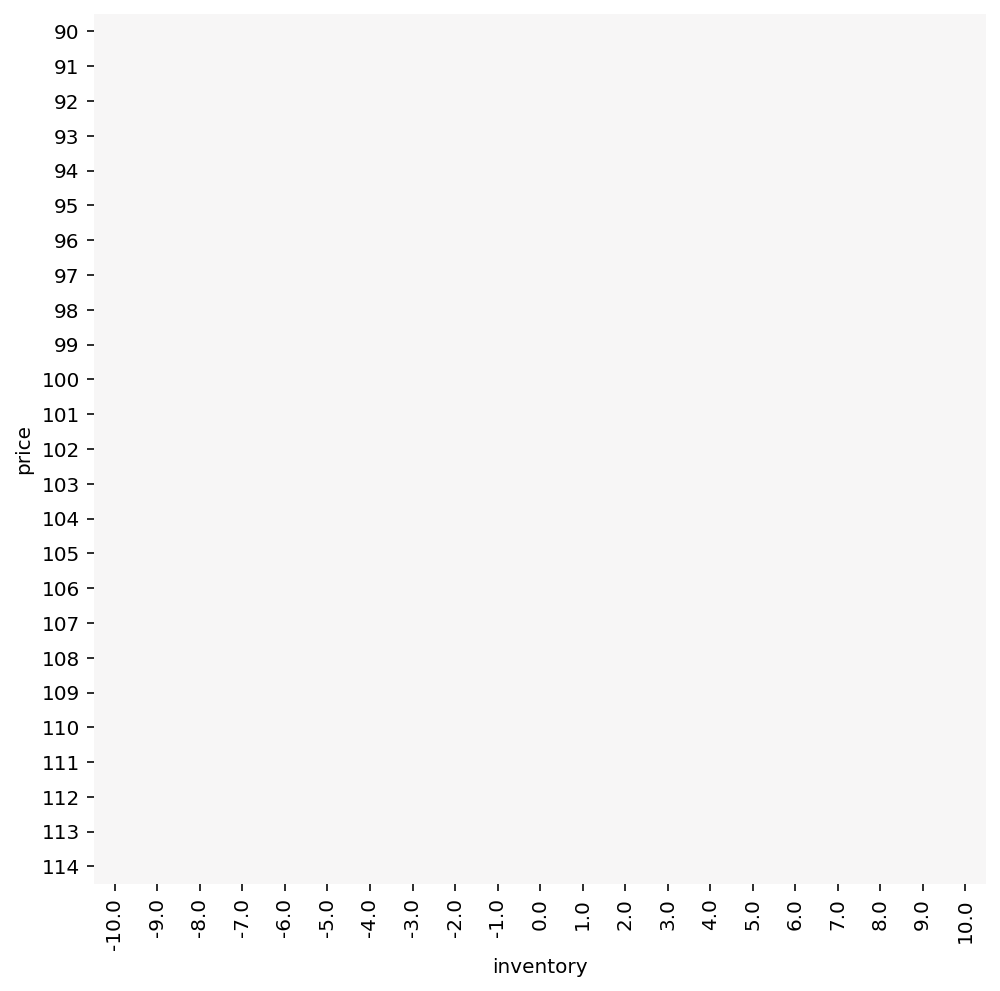

In [162]:
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(8, 8))

nframes = 30
def animate(i):
    ax.cla()
    Qselect = Qm.isel(time=i).to_dataframe("Q").reset_index().pivot_table(index="price", columns="inventory", values="Q")
    sns.heatmap(Qselect, cmap="RdBu_r", vmin=-4, vmax=4, ax=ax, cbar=False)
    
ani = animation.FuncAnimation(fig, animate, frames=nframes,
                              interval=100)
ani.save("rl-ou.gif", writer="imagemagick")

<AxesSubplot:xlabel='inventory', ylabel='price'>

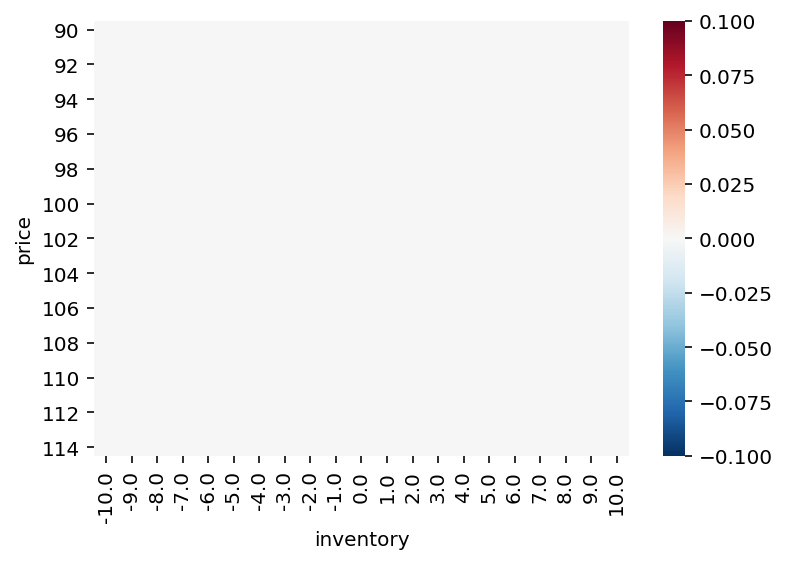

In [183]:
sns.heatmap(Qm.isel(time=23).to_dataframe("Q").reset_index().pivot_table(index="price", columns="inventory", values="Q"), cmap="RdBu_r")

<AxesSubplot:xlabel='inventory', ylabel='price'>

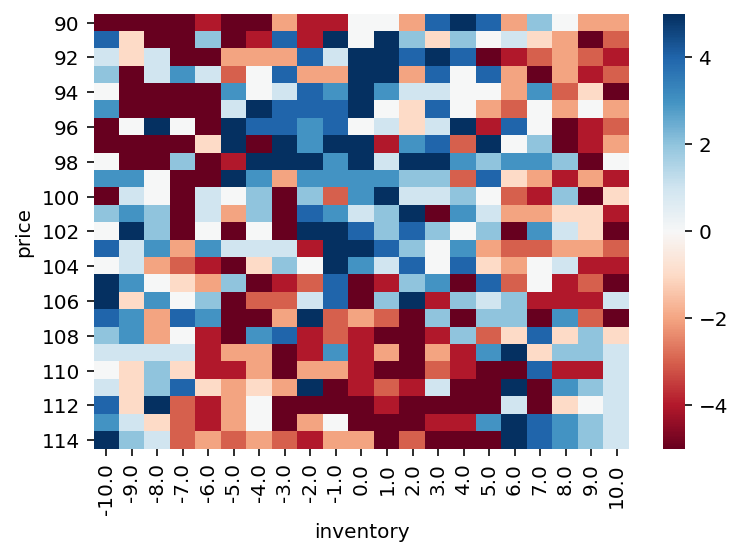

In [65]:
# heatmap values
hm_values = Qm.isel(time=8).argmax(dim="action").to_dataframe("A").reset_index()
hm_values = hm_values.pivot_table(index="price", columns="inventory", values="A") - 5
sns.heatmap(hm_values, cmap="RdBu", vmin=-5, vmax=5)

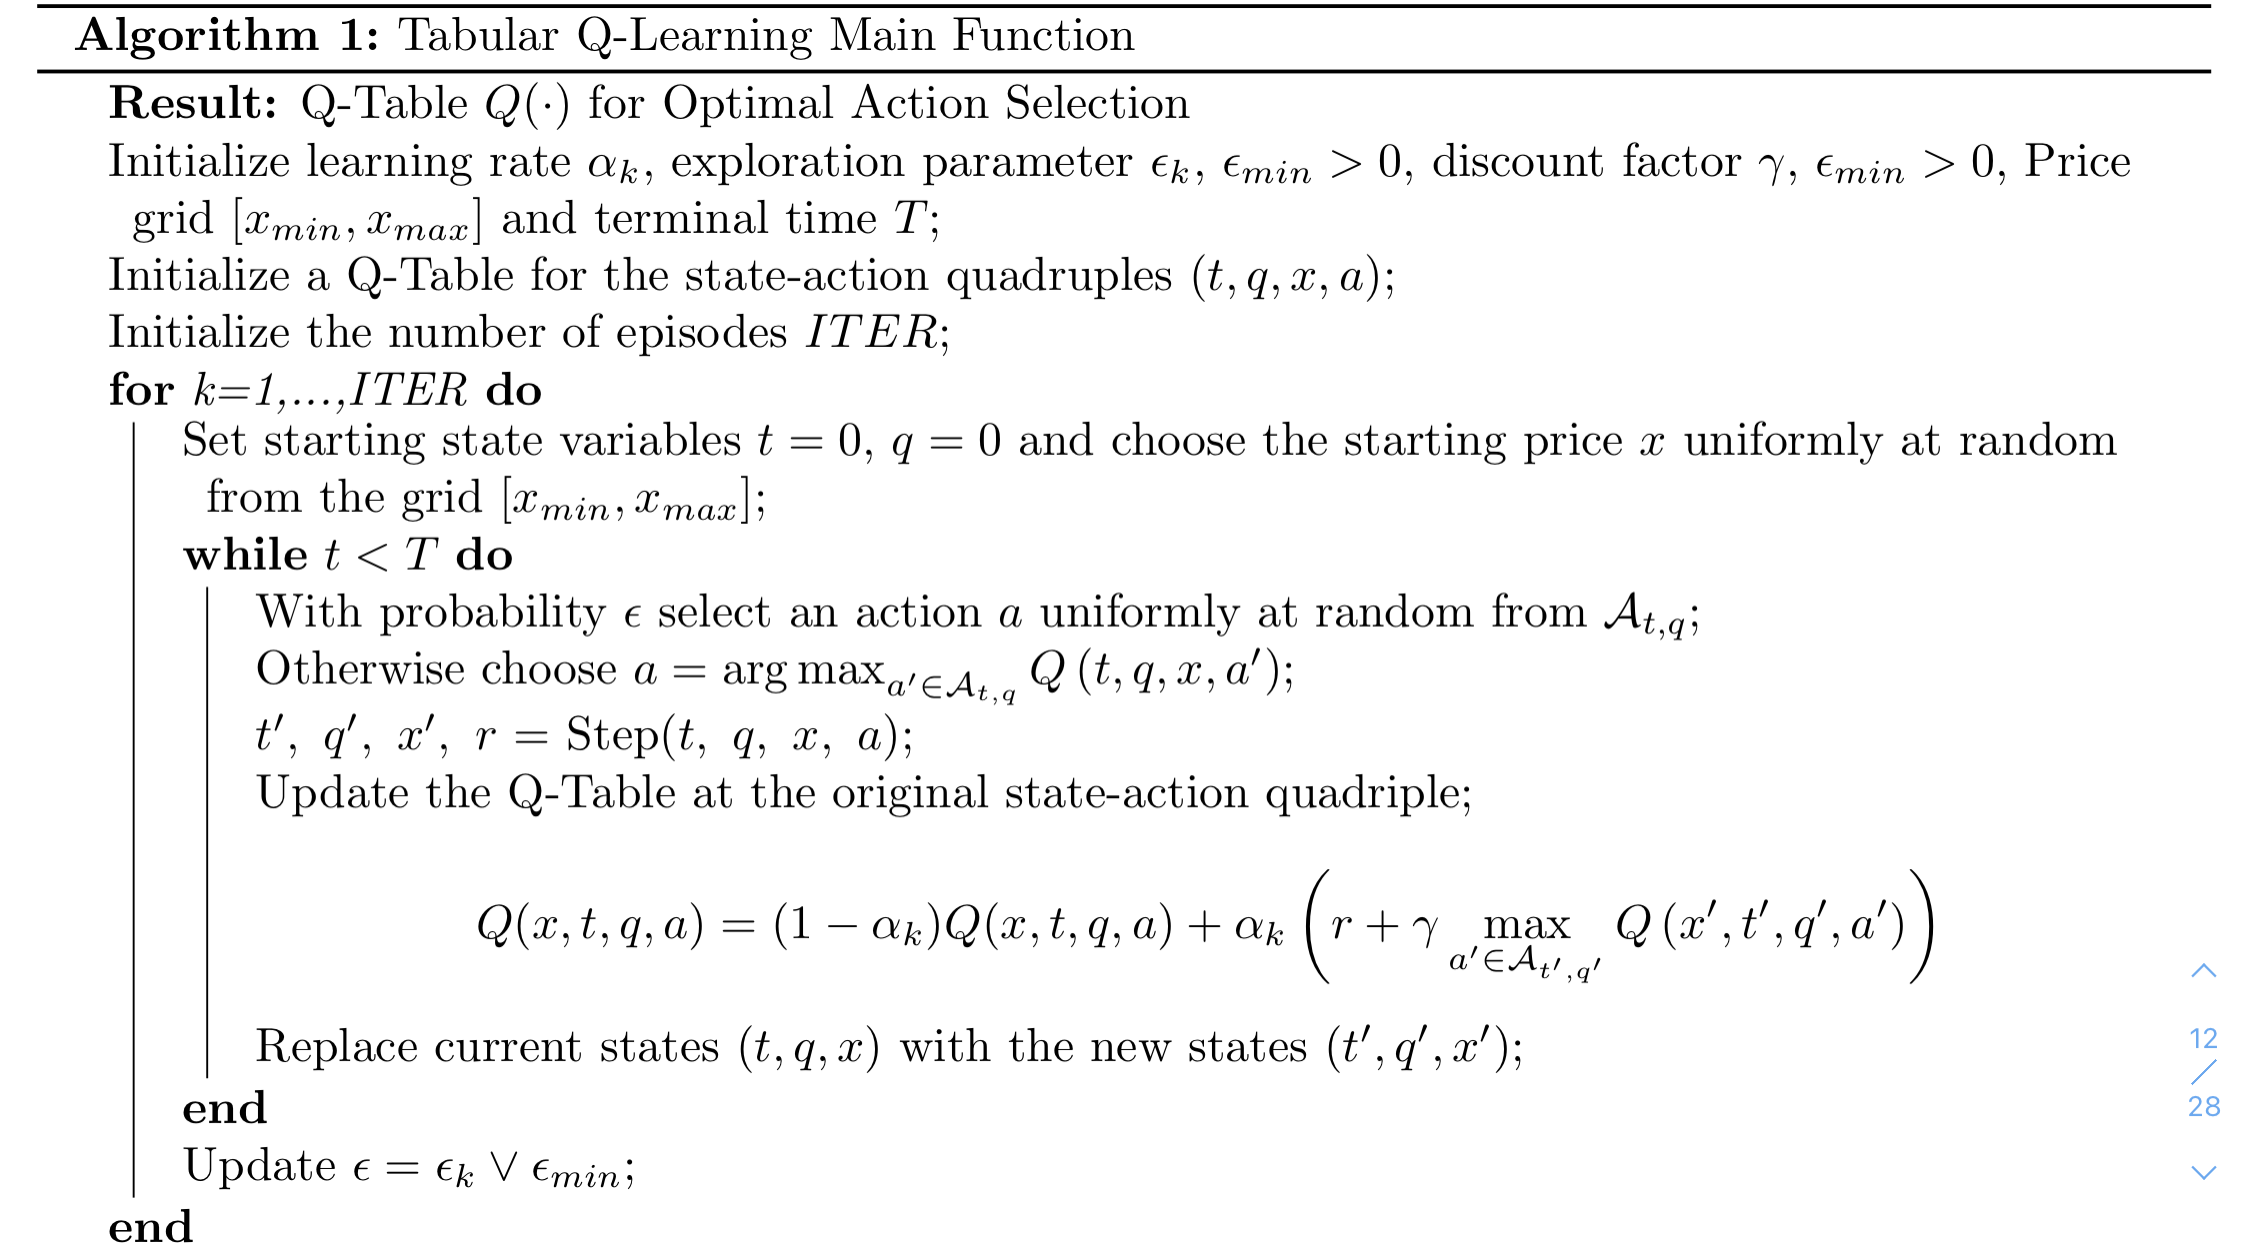

In [19]:
class QTrading:
    def __init__(self, kappa, sigma, xbar, phi, gamma=0.2, T=1, dt=0.01):
        self.kappa = kappa
        self.sigma = sigma
        self.xbar = xbar
        self.phi = phi
        self.gamma = gamma
        self.T = T
        self.dt = dt
        
    def next_price(self, price):
        discount_factor = np.exp(-self.kappa * self.dt)
        Z_2sigma = self.sigma ** 2 / (2 * self.kappa) * (1 - discount_factor ** 2)
        Z = np.sqrt(Z_2sigma) * randn()
        price = price * discount_factor + self.xbar * (1 - discount_factor) + Z

        return price
        
    def step(self, time, inventory, price, action):
        q_new = inventory + action
        new_price = self.next_price(price)
        t_new = time + self.dt
        if t_new < self.T:
            r = q_new * (new_price - price) - self.phi * action ** 2
        else:
            r = q_new * (new_price - price) - self.phi * action ** 2 - c * q_new** 2
        
        new_price = np.round(new_price, 1)
        return r, t_new, q_new, new_price

In [20]:
qtrading = QTrading(kappa=1, sigma=4, xbar=100, phi=.01)

In [21]:
learning_rate = 0.01
discount_factor = 0.8

In [24]:
reward_new, t_new, inventory_new, price_new = qtrading.step(0, 0, 100, 10)
Q_new_max = Q.sel(price=price_new, time=0.01, inventory=inventory_new).max().values

target_entry = {
    "time": 0,
    "price": 100,
    "inventory": 0,
    "action": 0
}

Q_update = ((1 - learning_rate) * Q.sel(target_entry) +
         learning_rate * (reward_new + discount_factor * Q_new_max))

In [25]:
Q.loc[target_entry] = Q_update.values

Q.sel(target_entry)

<xarray.DataArray ()>
array(-0.032)
Coordinates:
    time       float64 0.0
    price      float64 100.0
    inventory  int64 0
    action     int64 0